<a href="https://colab.research.google.com/github/mrdbourke/m1-machine-learning-test/blob/main/01_food101_effnet_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food101 EfficientNetB0 Feature Extraction Benchmark

The following notebook tests the speed at which a given device can perform training iterations on the Food101 dataset (~100,000 total images) using [EfficientNetB0](https://arxiv.org/abs/1905.11946) as a base model.

It's designed to be a simple test to compare Apple's M1 (normal, Pro, Max) to each other and other sources of compute.

| Model | Dataset | Train Size | Test Size |
| ----- | ----- | ----- | ----- |
| [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) (pretrained on ImageNet) | Food 101 ([from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/food101)) | ~75,000 images | ~25,000 images|

## Resources
* Code on GitHub: https://github.com/mrdbourke/m1-machine-learning-test
* Code in this notebook adapted from: https://dev.mrdbourke.com/tensorflow-deep-learning/07_food_vision_milestone_project_1/ 

## Check for GPU

If you're using Google Colab, you'll need to activate a GPU:
1. Go to "Runtime"
2. Go to "Change Runtime Type"
3. Select "GPU"
4. Click "Save" (this will restart the runtime)

If you're using a Mac with an M1 chip, the GPU should already be selected if you've installed TensorFlow correctly.

In [1]:
# This will error if not using a Nvidia GPU (only works on Colab)
!nvidia-smi

Sun Nov 14 23:08:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup hyperparameters

Change these to suit your needs.

The main one will be the device you're running code on.

E.g. `DEVICE = "Google Colab (K80 GPU)"` if using Google Colab.

In [40]:
# Setup hyperparameters
BATCH_SIZE = 32 # good for your health: https://twitter.com/ylecun/status/989610208497360896
EPOCHS = 5 # only run for a short period of time... we don't have all day
DATASET_NAME = "food101" # change this to try other image datasets from TensorFlow Datasets
DEVICE = "Google Colab (K80 GPU)" # Note: Change this depending on where you're running code

## Get helper functions and import dependencies

The function below downloads the helper functions if necessary (if running this notebook in Google Colab, it's easier to download a single file than clone the whole repo).

In [13]:
# Get helper functions
import os
import requests

if not os.path.exists("helper_functions.py"):
  print("Downloading helper functions...")
  r = requests.get("https://raw.githubusercontent.com/mrdbourke/m1-machine-learning-test/main/helper_functions.py")
  print("Writing helper functions to file...")
  open("helper_functions.py", "wb").write(r.content)
else:
  print("Helper functions already downloaded, skipping redownload.")

Writing helper functions to file...


In [14]:
# Check TensorFlow version
import tensorflow as tf
print(tf.__version__) # should be 2.5.0+

# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Get data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from timeit import default_timer as timer 
from helper_functions import print_train_time

2.7.0


## Download Data

We'll download the data from the Food101 dataset [stored in TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/food101). This dataset contains ~100,000 images and should be a good test to see how the machines go with a larger dataset.

> **Note:** Downloading the dataset (running the cell below) will download ~4.5GB of images to your local machine (or to Google Colab). Depending on your internet, it could take 5-20 minutes.



In [25]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name=DATASET_NAME, # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

## Check out dataset

Let's check a few things with the data to make sure it's okay to model. 

In [26]:
# Check number of samples
len(train_data), len(test_data)

(75750, 25250)

In [27]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10], len(class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 81
  Class name (str form): ramen
        


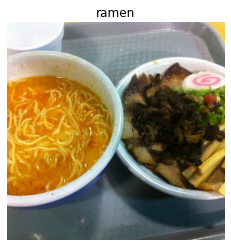

In [28]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)
  plt.imshow(image)
  plt.title(class_names[label.numpy()])
  plt.axis(False)

## Prepare data

The data looks good. But before we model it, we're going to prepare it to run as fast as possible using [TensorFlow data loading best practices](https://www.tensorflow.org/guide/data_performance).

As EfficientNetB0 takes images of size `(224, 224, 3)`, we'll resize all the images to that size.

In [29]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [30]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Setup model

We'll setup the model to use EfficientNetB0 pretrained on ImageNet as the base model. But we'll replace the top layers to be more suited to our Food101 problem (101 output neurons instead of the standard 1000 output neurons).

Also we'll run the model setup code before fitting the model so the model downloads to file separate from training (this will ensure the model downloading time won't add to the training time measure).

In [42]:
# Set random seed
tf.random.set_seed(42)

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x) # want one output neuron per class 
model = tf.keras.Model(inputs, outputs, name="EfficientNetB0_feature_extract")

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

## Fit the model

Let's fit the model and track it's performance.

We're not so much concerned of the accuracy as much as the time per epoch.

In [32]:
# Start timer
start_time = timer()

# Fit the model
history = model.fit(train_data, 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

# End timer
end_time = timer()

# Print results
train_time = print_train_time(start=start_time,
                              end=end_time,
                              device=DEVICE)

Epoch 1/5
2368/2368 [==============================] - 422s 162ms/step - loss: 1.8209 - accuracy: 0.5569 - val_loss: 1.2312 - val_accuracy: 0.6796
Epoch 2/5
2368/2368 [==============================] - 383s 161ms/step - loss: 1.2942 - accuracy: 0.6649 - val_loss: 1.1231 - val_accuracy: 0.7018
Epoch 3/5
2368/2368 [==============================] - 381s 160ms/step - loss: 1.1438 - accuracy: 0.7033 - val_loss: 1.0859 - val_accuracy: 0.7056
Epoch 4/5
2368/2368 [==============================] - 435s 183ms/step - loss: 1.0459 - accuracy: 0.7256 - val_loss: 1.0729 - val_accuracy: 0.7102
Epoch 5/5
2368/2368 [==============================] - 385s 162ms/step - loss: 0.9727 - accuracy: 0.7444 - val_loss: 1.0692 - val_accuracy: 0.7098

Train time on Google Colab (K80 GPU): 2033.500 seconds


## Track results and save to file

In [43]:
results = {
    "device": DEVICE,
    "dataset_name": DATASET_NAME,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "num_train_samples": len(train_data)*BATCH_SIZE,
    "num_test_samples": len(test_data)*BATCH_SIZE,
    "total_train_time": round(train_time, 3),
    "time_per_epoch": round(train_time/EPOCHS, 3),
    "model": model.name
    }
results_df = pd.DataFrame(results, index=[0])
results_df

,device,dataset_name,epochs,batch_size,num_train_samples,num_test_samples,total_train_time,time_per_epoch,model
0,Google Colab (K80 GPU),food101,5,32,75776,25280,2033.5,406.7,EfficientNetB0_feature_extract


In [46]:
# Write CSV to file
if not os.path.exists("results/"):
  os.makedirs("results/")

results_df.to_csv(f"results/{DEVICE}_{DATASET_NAME}")

## Extras

Make sure to delete the extra downloaded files (the Food101 dataset) if you do not want to keep them on your machine.